Number of classes, each class in a map, 
has number of names parameters - each parameter is vector


In [1]:
import json
from pprint import pprint
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib
matplotlib.style.use('ggplot')
#ols models
import statsmodels.formula.api as sm
from patsy import dmatrices
import re
import scipy as sp
from tools import print_columns
import csv

Estimating logit model
http://stackoverflow.com/questions/27558067/why-are-the-logistic-regression-results-different-between-statsmodels-and-r
https://community.jmp.com/thread/59720
http://stats.stackexchange.com/questions/9715/how-to-set-up-and-estimate-a-multinomial-logit-model-in-r
http://www.ats.ucla.edu/stat/r/dae/mlogit.htm
http://stackoverflow.com/questions/13656699/update-r-using-rstudio
https://cran.r-project.org/web/packages/mlogit/vignettes/mlogit.pdf
https://cran.r-project.org/web/packages/mlogit/vignettes/Exercises.pdf
http://wak2.web.rice.edu/bio/My%20Reprints/The%20no-choice%20alternative%20in%20conjoint%20experiments.pdf
https://cran.r-project.org/web/packages/mlogit/mlogit.pdf
    

In [8]:
ncdecisions = {'type1':{'scheme':{'EParamTypes::HONCDecisionSEIRating':[3.0]}, 'frequency':0.1},
              'type2':{'scheme':{'EParamTypes::HONCDecisionSEIRating':[4.0]}, 'frequency':0.5},
              'type3':{'scheme':{'EParamTypes::HONCDecisionSEIRating':[5.0]}, 'frequency':0.4}}

#TODO add total price


In [9]:
with open('ho-ncdecisions.json', 'w') as outfile:
    json.dump(ncdecisions, outfile)

In [4]:
installer_decisions = {'type1':{'scheme':{'EParamTypes::SEIRating':[0.3, 0.3, 0.3], 
                      'EParamTypes::SEIInteractionType':[0.2, 0.2, 0.2], 
                      'EParamTypes::SEIEquipmentType':[0.1, 0.1, 0.1], 
                      'EParamTypes::HOSEIDecisionProjectTotalTime':[0.5],
                     'EParamTypes::SEIWarranty':[0.2, 0.2, 0.2],
                     'EParamTypes::HOSEIDecisionEstimatedNetSavings':[0.7],
                      'EParamTypes::HODecisionSEIUtilityNone':[1.0]}, 'frequency':1.0}}

In [5]:
with open('ho-installerdecisions.json', 'w') as outfile:
    json.dump(installer_decisions, outfile)

In [6]:
design_decisions = {
  "type1": {
    "scheme": {
      "EParamTypes::HODesignDecisionPanelEfficiency":[1.0],
      "EParamTypes::HODesignDecisionPanelVisibility":[0.5, 0.5],
      "EParamTypes::HODesignDecisionInverterType":[0.1,0.1,0.1],
      "EParamTypes::HODesignDecisionFailures":[0.3],
      "EParamTypes::HODesignDecisionCO2":[0.2],
      "EParamTypes::HODesignDecisionEstimatedNetSavings":[0.5],
      "EParamTypes::HODesignDecisionUtilityNone":[1.0]
    },
    "frequency":1.0
  }
}


In [7]:
with open('ho-designdecisions.json', 'w') as outfile:
    json.dump(design_decisions, outfile)

In [26]:
def plot_xy(x_, y_, title_x, title_y):    
    xmin = x.min()
    xmax = x.max()
    ymin = -1.0
    ymax = 1.0

    plt.subplots_adjust(hspace=0.5)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.plot(x, y)
    plt.axis([xmin, xmax, ymin, ymax])
    ax.set_xlabel(title_x)
    ax.set_ylabel(title_y)

    plt_name = title_x + '-' + title_y + '.png'
    
    plt.savefig(plt_name, dpi=300)
    plt.show()

In [12]:
with open('../../ABMIRISLab/Source/Examples/BaseModel/ho-installerdecisions.json') as infile:
        data_raw = json.load(infile)

In [3]:
from os import listdir


In [9]:
listdir('../../ABMIRISLab/Source/Examples/BaseModel')

['.DS_Store',
 'basemodel.model',
 'df_installers.csv',
 'distribution.json',
 'g.json',
 'geography.json',
 'ho-designdecisions.json',
 'ho-installerdecisions.json',
 'ho-ncdecisions.json',
 'ho.json',
 'joint_distribution.csv',
 'market.json',
 'sei.json',
 'sem.json',
 'solar_equipment.json',
 'solar_module.json',
 'utility.json',
 'w.json']

In [13]:
print(data_raw)

{'type1': {'scheme': {'EParamTypes::SEIWarranty': [0.074677, 0.074677, 0.074677], 'EParamTypes::SEIEquipmentType': [-0.2166887, -0.0079533, 0.224642], 'EParamTypes::SEIRating': [-1.0403794, 0.2408452, 0.7995342], 'EParamTypes::HOSEIDecisionUtilityNone': [0.5197628], 'EParamTypes::SEIInteractionType': [-0.0257858, -0.0189546, 0.0447404], 'EParamTypes::HOSEIDecisionTotalProjectTime': [-0.1481597], 'EParamTypes::HOSEIDecisionEstimatedNetSavings': [3.64675]}, 'frequency': 1}}


In [ ]:
#assume that it is 15 years warranty
#equipment type middle 
#rating middle 
#interaction type middle 
#project time 1 month 
#savings 0.10 

In [14]:
data = data_raw['type1']['scheme']


In [20]:
utility = data['EParamTypes::SEIWarranty'][1] * 15 + \
            data['EParamTypes::SEIEquipmentType'][1] + \
            data['EParamTypes::SEIRating'][1] + \
            data['EParamTypes::SEIInteractionType'][1] + \
            data['EParamTypes::HOSEIDecisionTotalProjectTime'][0] * 1 + \
            data['EParamTypes::HOSEIDecisionEstimatedNetSavings'][0] * 0.5
            
print(utility)

3.0093076


In [22]:

def calculate_utility(savings):
    return data['EParamTypes::SEIWarranty'][1] * 15 + \
            data['EParamTypes::SEIEquipmentType'][1] + \
            data['EParamTypes::SEIRating'][1] + \
            data['EParamTypes::SEIInteractionType'][1] + \
            data['EParamTypes::HOSEIDecisionTotalProjectTime'][0] * 1 + \
            data['EParamTypes::HOSEIDecisionEstimatedNetSavings'][0] * savings 

[-2.4608174 -1.7314674 -1.0021174 -0.2727674  0.4565826  1.1859326
  1.9152826  2.6446326  3.3739826  4.1033326  4.8326826]
[-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]


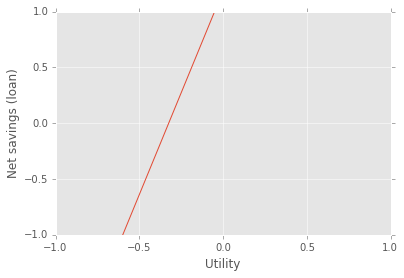

In [28]:
y = np.zeros(11)
x = np.zeros(11)
i = 0
#draw percent of a bill vs savings graph
for step in np.linspace(-1.0, 1.0, num=11):
    savings = step
    #call function, get percent_savings
    utility = calculate_utility(savings)
    y[i] = utility
    x[i] = savings
    i = i + 1

#print points
print(y)
print(x)
    
#draw graph
plot_xy(x, y, 'Utility','Net savings (loan)')